# Small Toxicological Studies Are Not Inherently Ethical

**Lyle D. Burgoon, Ph.D.**

**Raptor Pharm & Tox, Ltd**

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.



## Background

This jupyter notebook will examine the impacts of small sample sizes in toxicological studies.

## Analysis

There is a common misconception that low power studies are far more likely to be false negatives than false positives (https://ecfsapi.fcc.gov/file/1001332406626/Melnick-Commentary%20on%20the%20utility%20of%20the%20National%20Toxicology%20Program%20study.pdf). It has been shown repeatedly that this is not true (see https://journals.sagepub.com/doi/10.1177/1745691614551642?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed and https://openepidemiologyjournal.com/VOLUME/3/PAGE/16/). I'm going to demonstrate this point here as well. 

The simplest way to demonstrate that small sample size studies lead to false positives is to sample from the same distribution for both vehicle and treated groups. In this example, I have simulated a series of 10,000 draws from a random distribution, with mean 100, and standard deviation 10 for both control and treated groups (so 10,000 draws for each group). In an ideal sample, the mean difference should be 0, and the two groups should not be found to have a large effect size. In this example I am calculating Cohen’s d as the effect size. I am using 0.80 as the cut-off for “large” effect sizes.

The next code block sets up the functions that run the simulation. The `sim_cohen_d` function takes in the sample size (both groups must have the same sample size, for simplicity), the mean of the control group, the mean of the treated group, the standard deviation of the control group, and the standard deviation of the treated group. The function starts by random sampling from a normal distribution to build the vehicle. The `n` term is the sample size for the group. Next the function randomly samples from the same normal distribution to build the treatment group (when I run this I set the control and treated mean to the same value -- 100). Next, the cohen's d value is calculated and returned. 

The `sim_run` function actually runs the `sim_cohen_d` function. `sim_run` takes in the sample size (both groups must have the same sample size, for simplicity), the mean of the control group, the mean of the treated group, the standard deviation of the control group, the standard deviation of the treated group. The function runs 10,000 simulations of the `sim_cohen_d` function using the given parameters. The results are written into a dataframe, and returned.

In [1]:
library(ggplot2)
library(gridExtra)

sim_cohen_d <- function(n, c_mean, t_mean, sd1, sd2){
    vehicle <- rnorm(n, c_mean, sd1)
    treated <- rnorm(n, t_mean, sd2)
    pooled_sd <- sqrt(((n - 1) * sd1 + (n - 1) * sd2)/(n + n - 2))
    sim_cohen_d <- (mean(treated) - mean(vehicle)) / pooled_sd
    return(sim_cohen_d)
}

sim_run <- function(n, c_mean, t_mean, sd1, sd2){
  sim_cohen_d_vals <- vector()
  for(i in 1:10000){
    sim_cohen_d_vals[i] <- sim_cohen_d(n, c_mean, t_mean, sd1, sd2)
  }
  sim_cohen_d_df <- data.frame(cohen_d = sim_cohen_d_vals,
                               n = rep(n, length(sim_cohen_d_vals)))
  return(sim_cohen_d_df)
}

The next code block executes the simulations for sample sizes 3, 5, 7, 10, 15, 20, and 100, and puts the dataframes together into the `sim_cohen_d_df_all` dataframe. This is then plotted as a violin plot.

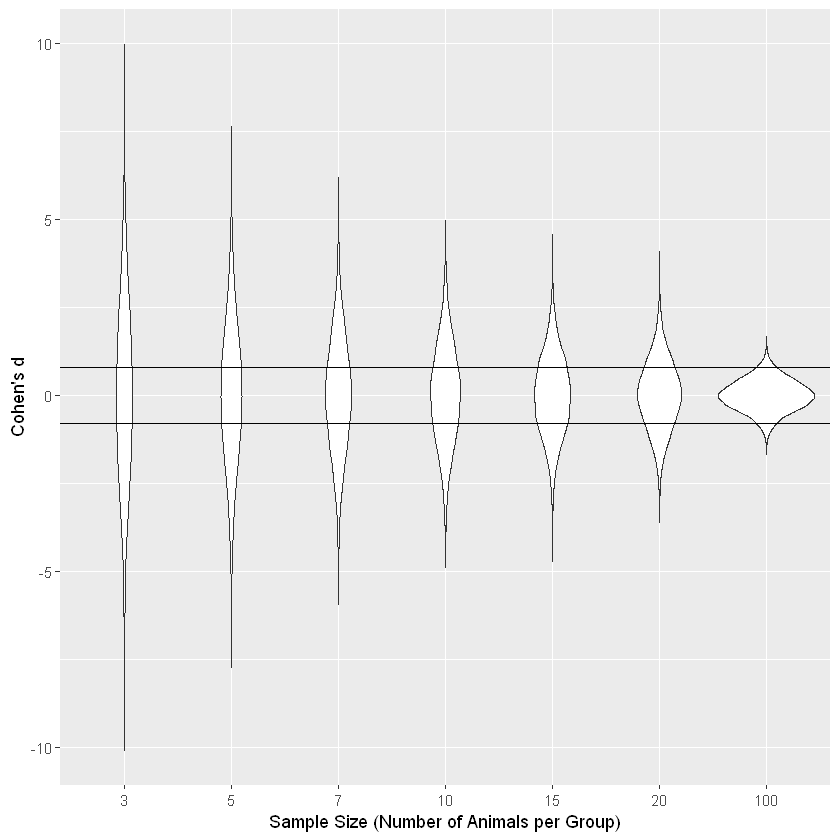

In [2]:
sim_cohen_d_df_3 <- sim_run(3, 100, 100, 10, 10)
sim_cohen_d_df_5 <- sim_run(5, 100, 100, 10, 10)
sim_cohen_d_df_7 <- sim_run(7, 100, 100, 10, 10)
sim_cohen_d_df_10 <- sim_run(10, 100, 100, 10, 10)
sim_cohen_d_df_15 <- sim_run(15, 100, 100, 10, 10)
sim_cohen_d_df_20 <- sim_run(20, 100, 100, 10, 10)
sim_cohen_d_df_100 <- sim_run(100, 100, 100, 10, 10)

sim_cohen_d_df_all <- rbind(sim_cohen_d_df_3,
                            sim_cohen_d_df_5,
                            sim_cohen_d_df_7,
                            sim_cohen_d_df_10,
                            sim_cohen_d_df_15,
                            sim_cohen_d_df_20,
                            sim_cohen_d_df_100)


ggplot(data = sim_cohen_d_df_all, aes(x = as.factor(n),
                                      y = cohen_d)) +
  geom_violin() +
  #geom_boxplot(width=0.05, fill="white") +
  geom_hline(yintercept = 0.8) +
  geom_hline(yintercept = -0.8) +
  ylab("Cohen's d") +
  xlab("Sample Size (Number of Animals per Group)")

The violin plot shows the histogram of the distribution for each sample size. The histogram for n = 3 is relatively flat. What this means is that there is not a large concentration of Cohen's d values in one spot, unlike for n=100. Thus, for n = 3, there is a large variance in the Cohen's d values, and many of these values are "large", meaning they are greater than 0.8 or less than -0.8 (the horizontal lines represent these thresholds). 

The number of Cohen's d values outside of the "large" threshold decreases as the number of animals per group increases. What this means is that the likelihood of having a statistically significant effect size decreases as the number of animals per group increases. This is because as the number of samples per group increases, the sample more accurately represents the population distribution. The fact that small number of animals per group tends to have outsized effect sizes, when the effect size should be 0, is a function of sampling error. 

We will demonstrate what this tends to look like with the next block of code.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



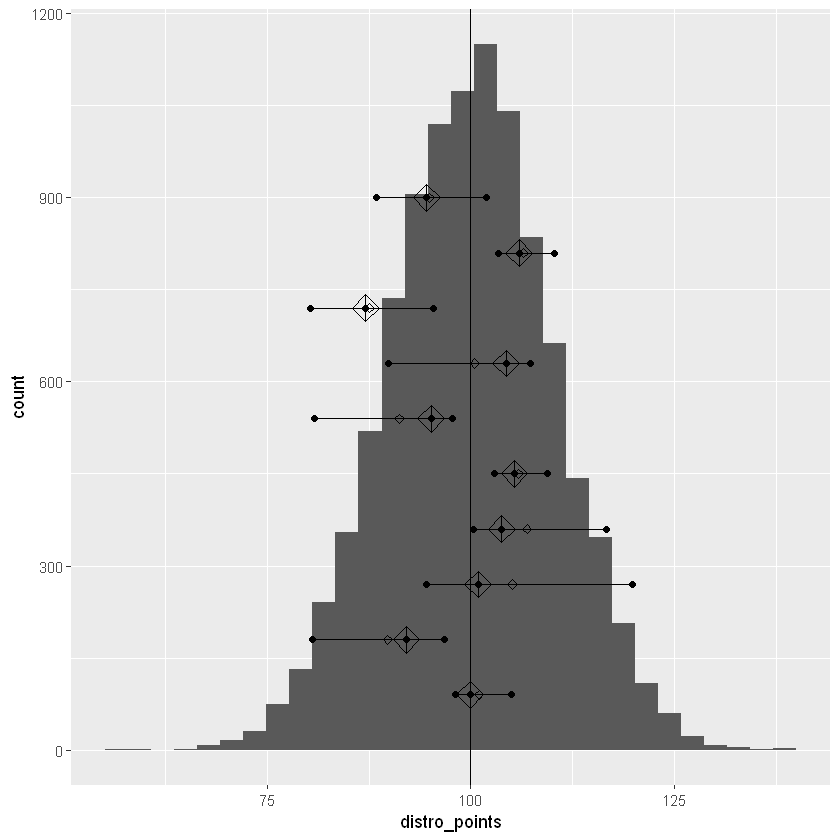

In [32]:
set.seed(1977)
x <- data.frame()
x2 <- data.frame()
x_means <- data.frame()
x_medians <- data.frame()

for(i in 1:10){
  z <- rnorm(3, 100, 10)
  z_df <- data.frame(trial = i * 90, 
                     min_point = min(z),
                     max_point = max(z))
  x <- rbind(x, z_df)
  
  z2_df <- data.frame(trial = rep(i * 90, 3),
                      points = z)
  
  x2 <- rbind(x2, z2_df)
  
  z_means <- data.frame(trial = i * 90,
                        mean = mean(z))
  
  x_means <- rbind(x_means, z_means)
  
  z_medians <- data.frame(trial = i * 90,
                        median = median(z))
  
  x_medians <- rbind(x_medians, z_medians)
}

base_distro <- data.frame(distro_points = rnorm(10000, 100, 10))

g2 <- ggplot(data = base_distro, aes(x=distro_points)) + 
  geom_histogram() +
  geom_vline(xintercept = mean(base_distro$distro_points))
  

g2 +
  geom_segment(data = x, aes(x = min_point, xend = max_point, y = trial, yend = trial)) +
  geom_point(data = x2, aes(x = points, y = trial)) +
  geom_point(data = x_means, aes(x = mean, y = trial), shape = 5) +
  geom_point(data = x_medians, aes(x = median, y = trial), shape = 9, size = 5)




Each horizontal line is a random draw from the underlying distribution (the dark histogram), for a total of 10 random draws. The dark circles on each line represent the 3 samples. The small unfilled diamond is the mean, and the large diamond is the median. As can be seen, the mean is pretty far from the population mean in several cases. The range in each of the draws is not nearly as large as we might expect given the standard deviation of the population. The mean and median for the sampling draws are also not centered on the population mean and median. Altogether, this points to the fact that a small number of samples will rarely recapitulate, on their own, the population they are drawn from. This is the essence of sampling error.

In [3]:
library(ggplot2)
library(gridExtra)

retrodesign <- function(A, s, alpha=.05, df=Inf, n.sims=10000){
  z <- qt(1-alpha/2, df)
  p.hi <- 1 - pt(z-A/s, df)
  p.lo <- pt(-z-A/s, df)
  power <- p.hi + p.lo
  typeS <- p.lo/power
  estimate <- A + s*rt(n.sims,df)
  significant <- abs(estimate) > s*z
  exaggeration <- mean(abs(estimate)[significant])/A
  return(list(power=power, typeS=typeS, exaggeration=exaggeration))
}

n_a <- 3
n_b <- 3
se_a <- 4.0
se_b <- 4.0
diff_estimates <- seq(0.01, 20, by=0.01)
se_difference_means <- sqrt((se_a)^2 + (se_b)^2)
pse <- sapply(diff_estimates, retrodesign, se_difference_means, alpha=0.05, df=n_a + n_b - 2, n.sims=10000)
t_pse <- t(pse)
df_pse <- data.frame(power=as.numeric(t_pse[,1]), typeS=as.numeric(t_pse[,2]), typeExaggeration=as.numeric(t_pse[,3]))


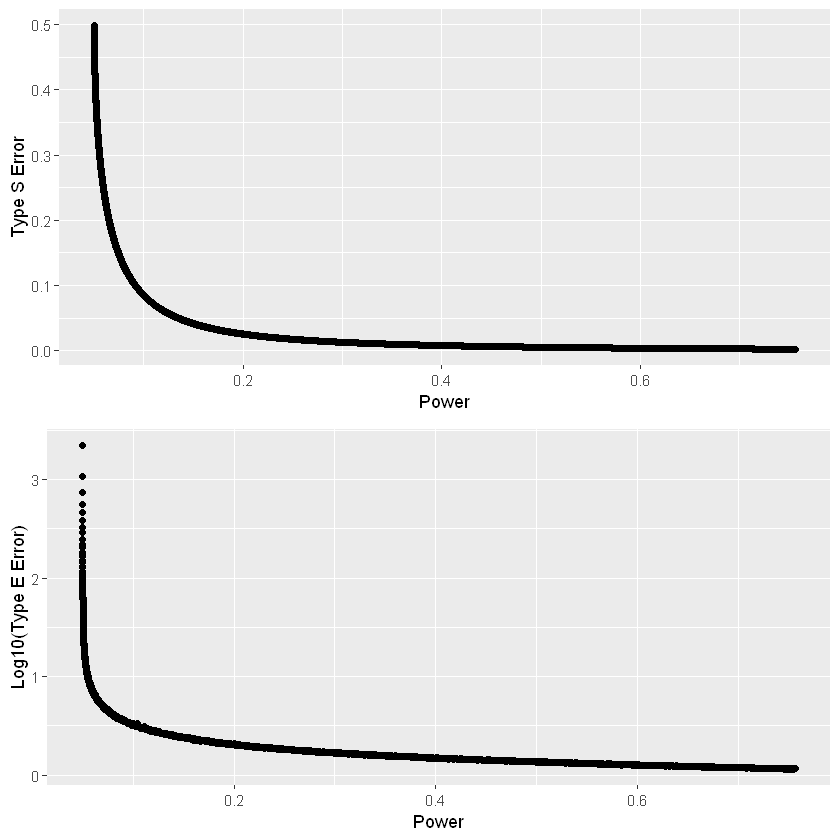

In [4]:
types_plot <- ggplot(df_pse, aes(x=power, y=typeS)) + 
  geom_point() +
  ylab("Type S Error") +
  xlab("Power")

typee_plot <- ggplot(df_pse, aes(x=power, y=log10(typeExaggeration))) +
  geom_point() +
  ylab("Log10(Type E Error)") +
  xlab("Power")


grid.arrange(types_plot, typee_plot, ncol=1)

What we see is that the Type S error gets larger as the power gets smaller. This is demonstrates that the likelihood of getting the sign wrong increases with smaller statistical power. 

What we see is that the Type E error gets larger as the power gets smaller. This is demonstrates that the likelihood of getting the sign wrong increases with smaller statistical power. Note that the y-axis here is on the log10 scale -- so a value of 1 is equivalent to 10, and 3 is equivalent to 1,000. At moderately low statistical power, such as 30-40%, the exaggeration is still prevalent. This complements the Cohen's d information I showed earlier, demonstrating that smaller sample sizes will generally exaggerate the effect size. 